In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#From signac
import signac
date_time_str = None
meth_name_str_list = [1, 2, 3, 4, 5]
study_id = "ep"
save_csv = True


criteria_dict = {"cs_name_val" : 2,
                 "param_name_str" : "y0",
                 "retrain_GP": 10,
                 "num_x_data": 5,
                 "num_val_pts": 0,
                 "lenscl": None}

df = pd.DataFrame()
job_list = []
for meth_name_val in meth_name_str_list:
    criteria_dict["meth_name_val"] = meth_name_val
    df_piece, jobs, name_cs_str, theta_true = get_study_data_signac(criteria_dict, study_id, save_csv)
    job_list += [job for job in jobs]
#     df_best = get_best_data(df_piece, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
    df = pd.concat([df, df_piece], ignore_index=True)
    
# df = df[df['EP Method Val'] == 4]

In [3]:
### Get Best Data from ep experiment
save_csv = True
df_best = get_best_data(df, study_id, name_cs_str, theta_true, job_list, date_time_str, save_csv)
df_best

# save_path = "Results/" + study_id + "_study/" + cs_name + "/" + param_name_str + "/" +  study_id + "_study_best.csv"
# df_best.to_csv(save_path, header = True)
# #Get Mean Data from ep experiment
# df_mean = get_mean_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
# df_mean

# #Get Median Data from ep experiment
# df_median = get_median_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)

# #Get Median of Best Data from ep experiment
# df_median_best = get_median_data(df_best, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
# df_median_best

,Run Number,BO Iter,Best Error,Exploration Bias,Max EI,Theta Max EI,Min Obj,Min Obj Act,Theta Min Obj,Min Obj Cum.,Theta Min Obj Cum.,Time/Iter,EP Method Val,BO Method,Max Evals,Total Run Time,L2 Norm Theta
35,13,1,112844.022531,1.0,0.0,"[-1.785522697428707, 1.513871650382233, 0.9561...",17561.613587,61431.907227,"[0.3420353008009523, -2.0, 0.0, 1.009136996573...",61431.907227,"[0.3420353008009523, -2.0, 0.0, 1.009136996573...",0.139521,1,A1,3,0.418563,2.935485
59,6,2,11.633762,1.0,0.0,"[0.3865958302752839, 0.059688701355287144, 1.9...",11.198131,11.699588,"[2.0, 0.39286802830510636, 1.7641983162349948,...",11.699588,"[2.0, 0.39286802830510636, 1.7641983162349948,...",0.410246,1,B1,3,1.230738,2.020228
599,11,57,37.120694,1.0,882.019718,"[-0.0026129174086711327, 0.4933121861468849, 1...",45.994886,35.677757,"[-0.0026153304293454753, 0.4933017201753367, 1...",35.677757,"[-0.0026153304293454753, 0.4933017201753367, 1...",1089.231827,1,A2,59,64264.677766,0.011525
730,0,19,11.633709,1.0,279.209008,"[-0.6274048388613718, -0.20070918286031647, 1....",10.874747,11.343344,"[-2.0, 0.6726516644401548, 1.470357839486535, ...",11.343344,"[-2.0, 0.6726516644401548, 1.470357839486535, ...",161.750979,1,B2,36,5823.035233,2.007983
1260,14,0,112844.022531,1.0,0.0,"[-0.5376238501428094, -1.5420921394617464, 1.2...",64541.902012,68006.282644,"[-1.1980190245432096, 0.47849715840638385, 1.9...",68006.282644,"[-1.1980190245432096, 0.47849715840638385, 1.9...",42.811267,1,C2,4,171.245068,1.285848


In [4]:
#Get only the jobs which are the best
project = signac.get_project()
job_list_best = []
for meth_name_val in meth_name_str_list:
    #Get best ep data from previous results if possible    
    criteria_dict_ep = criteria_dict.copy()
    criteria_dict_ep["meth_name_val"] = meth_name_val
    criteria_dict_ep["sep_fact"] = 1.0
    meth_name = Method_name_enum(meth_name_val).name
    
    path_name = job_list[0].fn(study_id + "_study_best_all.csv")
    df_ep_best = pd.read_csv(path_name, header = 0)
    best_ep_enum_val = int(df_ep_best["EP Method Val"][(df_ep_best['BO Method'] == meth_name)])
    criteria_dict_ep["ep_enum_val"] = best_ep_enum_val
    
    #Get all jobs with that ep enum val
    jobs_best = project.find_jobs(criteria_dict_ep)
    job_list_best += [job for job in jobs_best]

for i in range(len(job_list_best)): 
    print(job_list_best[i].id)

cd9fca2cc0e685bedb310073cf3d06eb
2cae46307674e66d32bbd97dc188afa1
93eb2fe14ef5ef207a7fbe09d99bd547
5521c16d631ba3c8ba047c351a77465d
8adf6602de7e3e082e87da1066e992f2


Method:  C2
Run Number:  15
BO Iter Number:  1
Trained Hyperparameters:  [array([3.04373658e+00, 1.42091875e+02, 1.37528322e+00, 1.72084569e-01,
       4.73144539e-02, 8.63728834e-03]), 0.0001, 1]


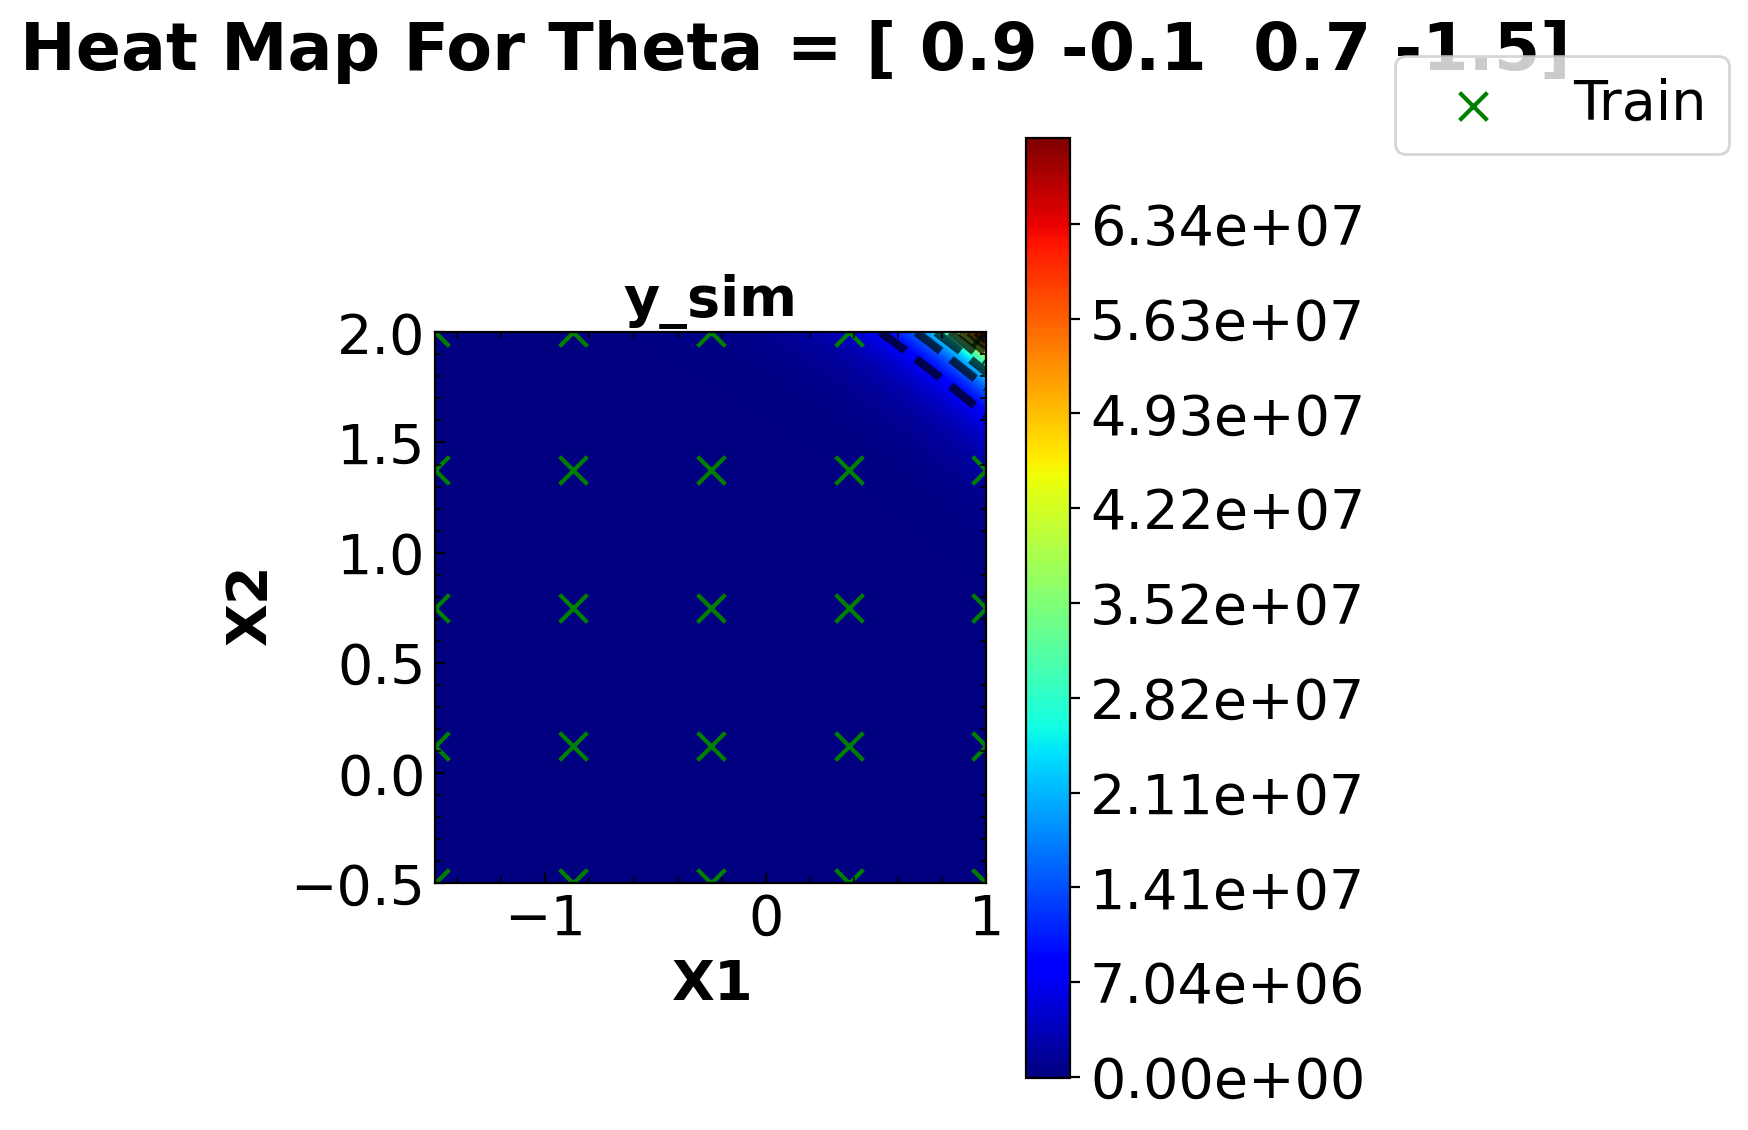

Max EI Theta [ 0.9346134  -0.14312267  0.65663397 -1.46321351]


In [11]:
#Plot Muller potential
project = signac.get_project()
meth_name_str_list = [5]
for meth_val in meth_name_str_list:
    criteria_dict["meth_name_val"] = meth_val
    jobs = project.find_jobs(criteria_dict) 
    for job in jobs:
        file_path = job.fn("BO_Results.gz")

    loaded_results = open_file_helper(file_path)
    meth_name = Method_name_enum(loaded_results[0].configuration["Method Name Enum Value"]).name


    run_num = df_best.loc[df_best['BO Method'].str.contains(meth_name), 'Run Number'].iloc[0] + 1
    bo_iter = df_best.loc[df_best['BO Method'].str.contains(meth_name), 'BO Iter'].iloc[0] + 1
    trained_hps = loaded_results[run_num-1].list_gp_emulator_class[bo_iter-1].trained_hyperparams
    print("Method: ", meth_name)
    print("Run Number: ", run_num)
    print("BO Iter Number: ", bo_iter)
    print("Trained Hyperparameters: ", trained_hps)
    x_val_num = 50
    theta_choice = None
    theta_true = loaded_results[run_num-1].simulator_class.theta_true
    theta_choice = theta_true  
#     theta_choice = np.array([-0.12334013, -1.97193209, -9.58736122,  0.70718457]) #(CS2_4 a 2A Set HPs)
#     theta_choice = np.array([-1.25179735, -1.30799798, -6.38989644,  0.69741102]) #(CS2_4 a 2A Trained HPs)   
#     theta_choice = np.array([-1.52838065,  0.76858661, -8.32826196, -0.15766997]) #(CS2_4 a 2C Set HPs)
#     theta_choice = np.array([-0.002612917, 0.493312186, 1.491001765, 0.999614708])  #(CS2_4 y0 2A Trained HPs) 
    theta_choice = np.array([ 0.9346134,  -0.14312267,  0.65663397, -1.46321351])  #(CS2_4 y0 2C Trained HPs) 

    seed = loaded_results[0].configuration["Seed"]

    title_fontsize = 24
    other_fontsize = 20
    xbins = 4
    ybins = 5
    zbins = 900
    save_path = None
    cmap = "autumn"
    save_path = None

    data_vals = compare_muller_heat_map(file_path, run_num, bo_iter, x_val_num, theta_choice, seed)
    test_mesh, y_sim, gp_mean, gp_var, theta_value, train_X, idcs_to_plot = data_vals
    title = "Heat Map For Theta = " + str(np.round(theta_value,1))

    z = [y_sim]
    z_titles = ["y_sim"]
    
#     z = [y_sim,  gp_mean, gp_var]
#     z_titles = ["y_sim" , "y_gp", "y_var"]
    
    cmap = "jet"
    levels = [100,100,100]
    plot_axis_names = ["X1", "X2"]
    try:
        plot_heat_maps(test_mesh, None, None, None, train_X, plot_axis_names, levels, idcs_to_plot, z, 
                   z_titles, xbins, ybins, zbins, title, title_fontsize, other_fontsize, cmap, save_path)
    except:
        pass
print("Max EI Theta", theta_choice)